In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_folder_path = 'train'
train_files = os.listdir(train_folder_path)


def process_json_to_df(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    ovens_data = []
    for oven in data['ovens']:
        for temp in oven['working_temps']:
            ovens_data.append({
                "start_temp": oven['start_temp'],
                "working_temp": temp,
                "operations": ', '.join(oven['operations'])
                 })

    series_data = []
    for series in data['series']:
        for operation in series['operations']:
            series_data.append({
                "target_temp": series['temperature'],
                "operation_name": operation['name'],
                "operation_timing": operation['timing']
                })

    return pd.DataFrame(ovens_data), pd.DataFrame(series_data)

all_ovens_data = []
all_series_data = []

for file in train_files:
    ovens_df, series_df = process_json_to_df(os.path.join(train_folder_path, file))
    all_ovens_data.append(ovens_df)
    all_series_data.append(series_df)

combined_ovens_df = pd.concat(all_ovens_data, ignore_index=True)
combined_series_df = pd.concat(all_series_data, ignore_index=True)


In [2]:
combined_ovens_df

,start_temp,working_temp,operations
0,1010,960,kovka
1,1010,1180,kovka
2,1010,1110,kovka
3,1010,1010,kovka
4,980,1040,"prokat, prokat"
...,...,...,...
228556,1030,980,"kovka, kovka"
228557,1030,950,"kovka, kovka"
228558,1030,1080,"kovka, kovka"
228559,1030,1210,"kovka, kovka"


In [3]:
combined_ovens_df.info

<bound method DataFrame.info of         start_temp  working_temp      operations
0             1010           960           kovka
1             1010          1180           kovka
2             1010          1110           kovka
3             1010          1010           kovka
4              980          1040  prokat, prokat
...            ...           ...             ...
228556        1030           980    kovka, kovka
228557        1030           950    kovka, kovka
228558        1030          1080    kovka, kovka
228559        1030          1210    kovka, kovka
228560        1030          1030    kovka, kovka

[228561 rows x 3 columns]>

In [4]:
combined_series_df

,target_temp,operation_name,operation_timing
0,980,nagrev,296
1,980,kovka,10
2,980,kovka,10
3,980,kovka,10
4,960,nagrev,299
...,...,...,...
498175,950,prokat,15
498176,1050,nagrev,99
498177,1050,kovka,15
498178,1060,nagrev,277


In [5]:
combined_series_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498180 entries, 0 to 498179
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   target_temp       498180 non-null  int64 
 1   operation_name    498180 non-null  object
 2   operation_timing  498180 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.4+ MB


In [6]:
missing_data_ovens = combined_ovens_df.isnull().sum()
missing_data_series = combined_series_df.isnull().sum()

missing_data_ovens, missing_data_series


(start_temp      0
 working_temp    0
 operations      0
 dtype: int64,
 target_temp         0
 operation_name      0
 operation_timing    0
 dtype: int64)

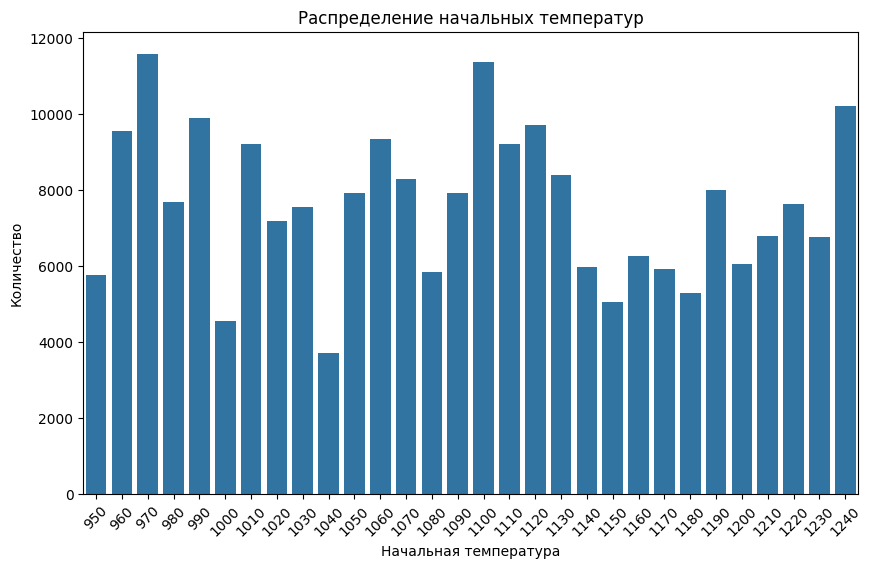

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_ovens_df, x='start_temp')
plt.title('Распределение начальных температур')
plt.xlabel('Начальная температура')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

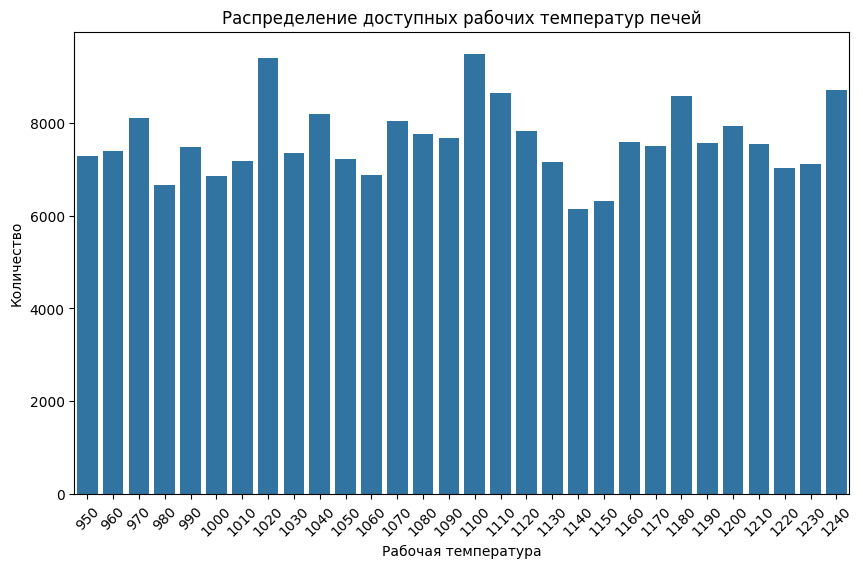

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_ovens_df, x='working_temp')
plt.title('Распределение доступных рабочих температур печей')
plt.xlabel('Рабочая температура')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

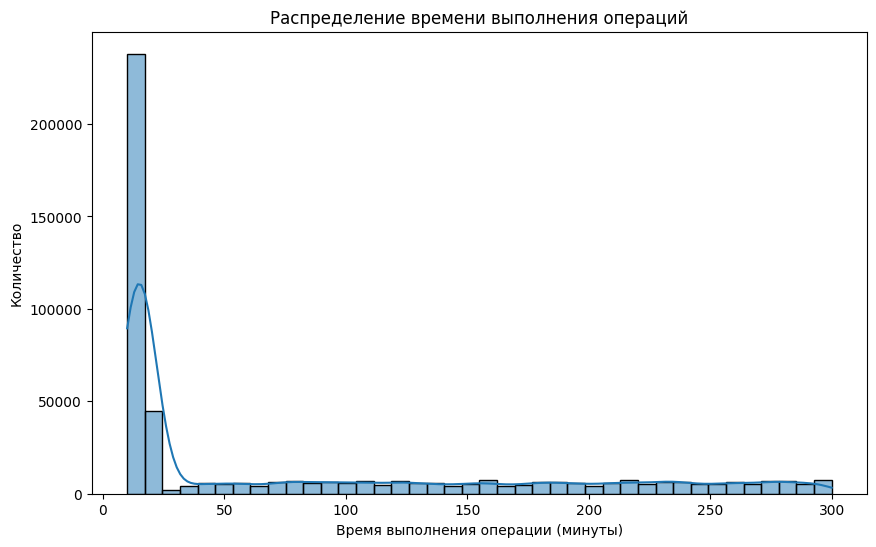

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_series_df, x='operation_timing', bins=40, kde=True)
plt.title('Распределение времени выполнения операций')
plt.xlabel('Время выполнения операции (минуты)')
plt.ylabel('Количество')
plt.show()

In [10]:
combined_series_df['operation_timing'].value_counts()

operation_timing
15     191590
10      46461
20      44877
279      1940
106      1721
        ...  
141       246
267       244
33        242
98        220
246        93
Name: count, Length: 274, dtype: int64

## Проверим корреляцию количества ковок и времени работы.

In [11]:
day_load_data = []

for file in train_files:
    day = file.split('.')[0]  
    _, series_df = process_json_to_df(os.path.join(train_folder_path, file))
    total_operation_time = series_df['operation_timing'].sum()  
    day_load_data.append({'day': day, 'total_operation_time': total_operation_time})

day_load_df = pd.DataFrame(day_load_data)

days_with_max_load = day_load_df.sort_values(by='total_operation_time', ascending=False).head()
days_with_max_load

,day,total_operation_time
68,day-25,556410
69,day-9,555921
45,day-82,550956
65,day-40,537787
56,day-78,534576


In [12]:
def count_kovka_operations(file_path):
    _, series_df = process_json_to_df(file_path)
    kovka_count = series_df[series_df['operation_name'] == 'kovka'].shape[0]
    return kovka_count

kovka_per_day = []

for file in train_files:
    day = file.split('.')[0] 
    kovka_count = count_kovka_operations(os.path.join(train_folder_path, file))
    kovka_per_day.append({'day': day, 'kovka_count': kovka_count})

kovka_per_day_df = pd.DataFrame(kovka_per_day)
top_days_kovka = kovka_per_day_df.sort_values(by='kovka_count', ascending=False).head()
top_days_kovka


,day,kovka_count
69,day-9,1961
45,day-82,1908
68,day-25,1908
81,day-12,1877
65,day-40,1866


In [13]:
day_data = []

for file in train_files:
    day = file.split('.')[1]
    day_path = os.path.join(train_folder_path, file)
    with open(day_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        total_time = sum(op['timing'] for series in data['series'] for op in series['operations'])
        kovka_count = sum(op['name'] == 'kovka' for series in data['series'] for op in series['operations'])
        day_data.append((day, total_time, kovka_count))

correlation_df = pd.DataFrame(day_data, columns=['day', 'total_operation_time', 'kovka_count'])

correlation = correlation_df[['total_operation_time', 'kovka_count']].corr()
correlation

,total_operation_time,kovka_count
total_operation_time,1.000000,0.996463
kovka_count,0.996463,1.000000


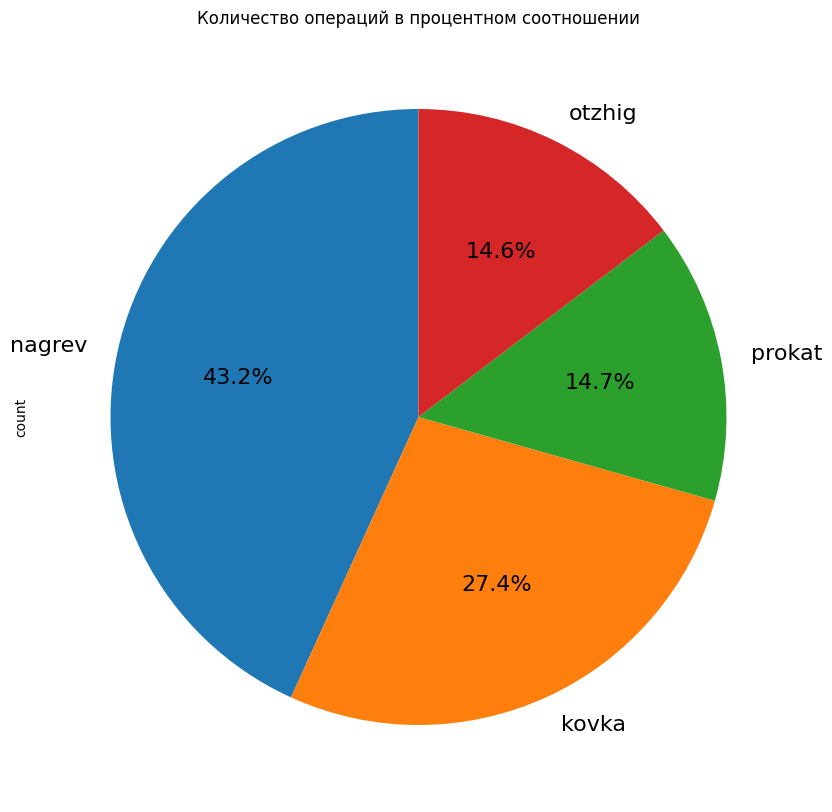

In [14]:
operation_counts = combined_series_df['operation_name'].value_counts()
operation_counts.plot(kind='pie', figsize=(10, 10), autopct='%1.1f%%', startangle=90, fontsize=16)
plt.title('Количество операций в процентном соотношении')
plt.show()